## SIRS model with fractional laplacian

We consider a spatialy heterogenenou SIR model. This can be described in terms of system of partial differential equations:
\begin{align*}
    \frac{dS(t, x)}{dt} &= -\beta \frac{S(t, x) I(t, x)}{N(t, x)} + \omega R(t, x) - (-\Delta)^{\alpha/2}S(t, x)\\
    \frac{dI(t, x)}{dt} &= \beta \frac{S(t, x) I(t, x)}{N(t, x)} - \gamma I(t, x) - (-\Delta)^{\alpha/2}I(t, x)\\
    \frac{dR(t, x)}{dt} &= \gamma I(t, x) - \omega R(t, x) - (-\Delta)^{\alpha/2}R(t, x)\\
\end{align*}
for $t \geq 0$ and $x \in [0, L]$.

With initial conditions:
\begin{align*}
    S(t, x)|_{t=0} &= S_{0}(x),\\
    I(t, x)|_{t=0} &= I_{0}(x),\\
    R(t, x)|_{t=0} &= R_{0}(x).
\end{align*}
and boundary conditions of Neumann type:
\begin{align*}
    \left.\frac{\partial S(t, x)}{\partial x}\right|_{x=0} = \left.\frac{\partial S(t, x)}{\partial x}\right|_{x=L} &= 0\\
    \left.\frac{\partial I(t, x)}{\partial x}\right|_{x=0} = \left.\frac{\partial I(t, x)}{\partial x}\right|_{x=L} &= 0\\
    \left.\frac{\partial R(t, x)}{\partial x}\right|_{x=0} = \left.\frac{\partial R(t, x)}{\partial x}\right|_{x=L} &= 0
\end{align*}

We use method of lines to calculate the solution of the model. We discretize spatial axis into $k$ sub-intervals (where $k = 2^n$ for some $n$, which ensures some speedup). Then we take the midpoint of each sub-interval as representative. This way we can use DCT, type II ("the" DCT) to calculate fractional laplacian efficiently, i.e. in $O(k \log k)$ time instad of $O(k^2)$ time with naïve matrix-multiplication method.

In [3]:
using DifferentialEquations
using StaticArrays

import FFTW: dct, idct
import SpecialFunctions: beta
import PyPlot as plt

In [4]:
L = 1.;
k = 2^6;
t_max = 0.5

κ = 0.;
α = 1

β, γ, ω = 110, 36, 8

(110, 36, 8)

In [5]:
N = 100000 / k
x = collect(1:2:2*k) .* (L/(2*k))

A = -0.5
B = 500

N_0 = fill(N, k)
I_0 = (cos.(x*(2*pi/L)) .+ 1) ./ L
I_0 = (15*cos.(x*(pi/L)) - 5*cos.(3x*(pi/L)) + 3*cos.(5x*(pi/L)) .+ 15) ./ (15L)
#I_0 = (x.^A .* (L.-x).^B) ./ (beta(A+1, B+1) * L^(A+B+1))
R_0 = zeros(k)
S_0 = N_0 - I_0 - R_0;

initial_state = [S_0; I_0; R_0]

tspan = (0., t_max)
ts = LinRange(tspan[1], tspan[2], 1001);

In [6]:
freqs = collect(0:(k-1)) .* (pi / L)
freqs_α = freqs .^ α
function fractional_laplacian(f, κ=κ, freqs_α=freqs_α)
    coef = dct(f)
    κ .* idct(-freqs_α .* coef)
end;

In [7]:
function model!(ret, state, params, t)
    β, γ, ω = params
    
    S = state[1     : k  ]
    I = state[k+1   : 2*k]
    R = state[2*k+1 : 3*k]
    N = S + I + R
    
    ret[1     :   k] = -β.*(S.*I) ./ N .+ ω.*R + κ*fractional_laplacian(S)
    ret[k+1   : 2*k] =  β.*(S.*I)./N .- γ.*I + κ*fractional_laplacian(I)
    ret[2*k+1 : end] =  γ.*I .- ω.*R .+ κ*fractional_laplacian(R)
    
    nothing
end;

In [8]:
prob = ODEProblem(model!, initial_state, tspan, (β, γ, ω), saveat=ts);
# sol = solve(prob, BS3());

sol = solve(prob, KuttaPRK2p5(), dt=1/k);

In [9]:
u = reduce(hcat, sol.u)
S = u[1:k, :];
I = u[k+1: 2k, :]
R = u[2k+1: 3k, :];

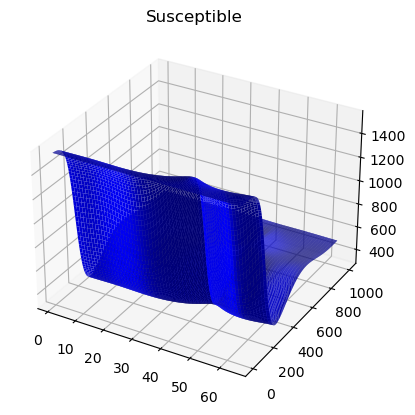

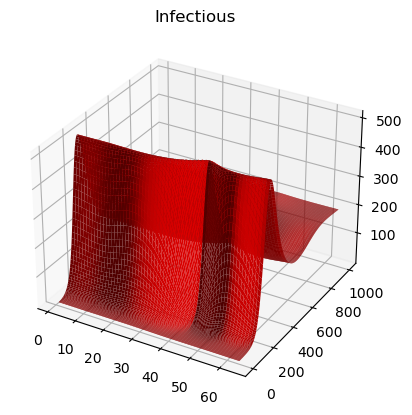

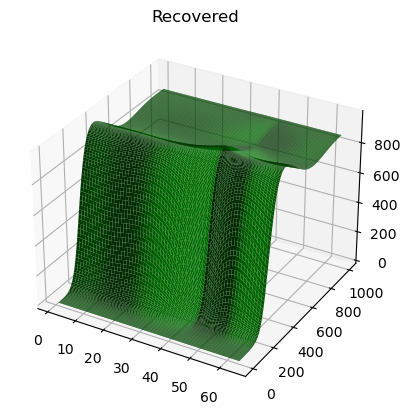

In [11]:
rcount = min(k, 2^6)
ccount = min(length(sol.t), 251)

plt.figure()
plt.surf(S, rcount=rcount, ccount=ccount, color="b")
plt.title("Susceptible")

plt.figure()
plt.surf(I, rcount=rcount, ccount=ccount, color="r")
plt.title("Infectious")

plt.figure()
plt.surf(R, rcount=rcount, ccount=ccount, color="g")
plt.title("Recovered");

# TODO: upraviť osi, aby zobrazovali naozajstné hodnoty, nie iba 0...1000

In [79]:
function SIRS_diffusion(S_0, I_0, R_0, β, γ, ω, μ, p, L, t_max, κ, α, solver=BS3())
    k = length(S_0)
    @assert length(I_0) == k "S_0 and I_0 have different length!"
    @assert length(R_0) == k "S_0 and R_0 have different length!"
    
    @assert all(S_0 .>= 0) "S_0 (initial condition for susceptible) must be non-negative!"
    @assert all(I_0 .>= 0) "I_0 (initial condition for infectious) must be non-negative!"
    @assert all(R_0 .>= 0) "R_0 (initial condition for recovered) must be non-negative!"
    
    @assert β >= 0 "Parameter β (force of infection) must be non-negativ!e"
    @assert γ >= 0 "Parameter γ (rate of recovery) must be non-negative!"
    @assert ω >= 0 "Parameter ω (rate of immunity loss) must be non-negative!"
    @assert μ >= 0 "Parameter μ (birth/death rate) must be non-negative!"
    @assert p >= 0 "Parameter p (proportion of vaccinated newborns) must be non-negative!"
    
    @assert L > 0 "Parameter L (length of spatial dimension) must be positive!"
    @assert t_max > 0 "Parameter t_max (time scope) must be positive!"
    
    @assert κ >= 0 "Parameter κ (diffusion rate) must be non-negative!"
    @assert 1 <= α <= 2 "Parameter α (diffusion exponent) must be non-negative!"
    
    x = collect(1:2:2*k) .* (L/(2*k))
    tspan = (0., t_max)
    ts = LinRange(tspan[1], tspan[2], 1001)
    
    initial_state = [S_0; I_0; R_0]
    
    freqs = collect(0:(k-1)) .* (pi / L)
    freqs_α = freqs .^ α
    function fractional_laplacian(f, κ=κ, freqs_α=freqs_α)
        coef = dct(f)
        κ .* idct(-freqs_α .* coef)
    end
    
    function model!(ret, state, params, t)
        β, γ, ω, μ, p = params

        S = state[1     : k  ]
        I = state[k+1   : 2*k]
        R = state[2*k+1 : 3*k]
        N = S + I + R

        ret[1     :   k] = -β*(S.*I)./ N + ω*R - μ*S + μ*(1-p)*N + κ*fractional_laplacian(S)
        ret[k+1   : 2*k] =  β*(S.*I)./N - (γ+μ)*I + κ*fractional_laplacian(I)
        ret[2*k+1 : end] =  γ*I - (ω+μ)*R + μ*p*N + κ*fractional_laplacian(R)

        nothing
    end;
    
    prob = ODEProblem(model!, initial_state, tspan, (β, γ, ω, μ, p), saveat=ts);
    sol = solve(prob, solver);
    
    u = reduce(hcat, sol.u)
    S = u[1:k, :];
    I = u[k+1: 2k, :]
    R = u[2k+1: 3k, :];
    
    rcount = min(k, 2^6)
    ccount = min(length(sol.t), 251)

    plt.figure()
    plt.surf(S, rcount=rcount, ccount=ccount, color="b")
    plt.title("Susceptible")

    plt.figure()
    plt.surf(I, rcount=rcount, ccount=ccount, color="r")
    plt.title("Infectious")

    plt.figure()
    plt.surf(R, rcount=rcount, ccount=ccount, color="g")
    plt.title("Recovered");

    # TODO: upraviť osi, aby zobrazovali naozajstné hodnoty, nie iba 0...1000
    
    sol;
end;

In [92]:
L = 1.
k = 2^6
t_max = 1/12

κ = 0.5
α = 1

β, γ, ω = 110, 36, 8
μ = 1/72
p = 0.

x = collect(1:2:2*k) .* (L/(2*k))
#A = -0.5
#B = 500

N_0 = fill(100_000/k, k)
I_0 = (cos.(x*(2*pi/L)) .+ 1) ./ L
I_0 = (15*cos.(x*(pi/L)) - 5*cos.(3x*(pi/L)) + 3*cos.(5x*(pi/L)) .+ 15) ./ (15L)
I_0 = (0.5*cos.(x*(pi/L)) + √3/4*cos.(2x*(pi/L)) + 1/3*cos.(3x*(pi/L)) + √3/8*cos.(4x*(pi/L)) + 1/10*cos.(5x*(pi/L)) .+ 0.5) ./ (L/2)
#I_0 = (x.^A .* (L.-x).^B) ./ (beta(A+1, B+1) * L^(A+B+1))
R_0 = zeros(k)
S_0 = N_0 - I_0 - R_0;

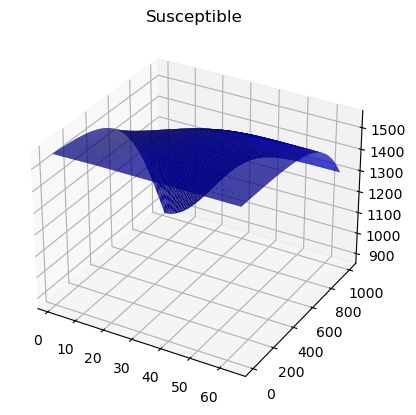

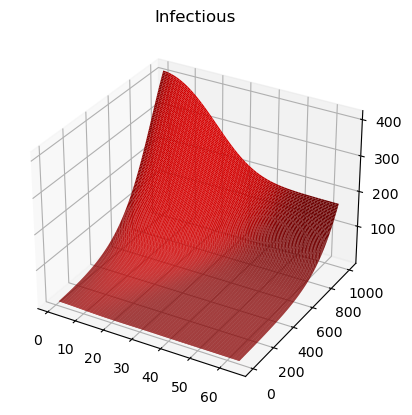

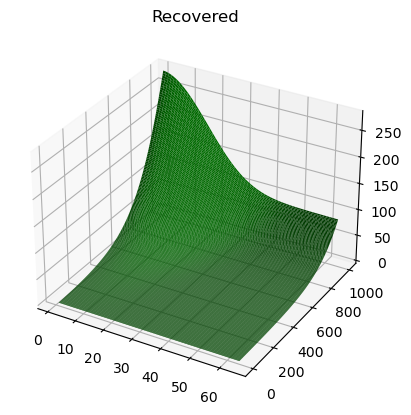

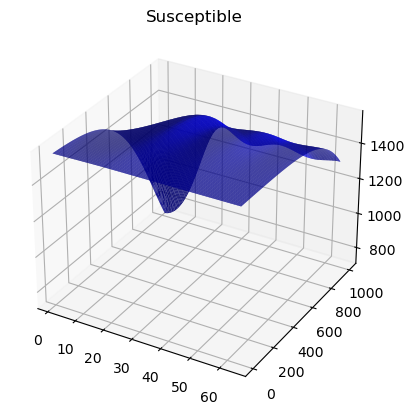

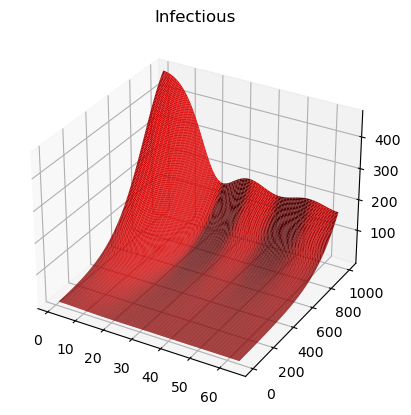

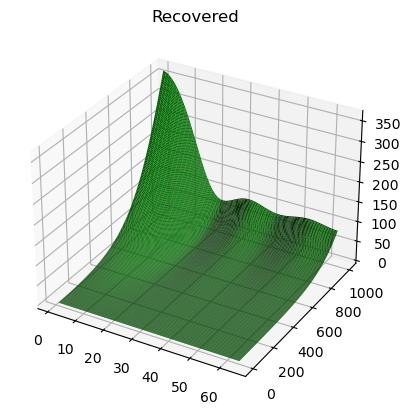

In [93]:
α = 2.
sol = SIRS_diffusion(S_0, I_0, R_0, β, γ, ω, μ, p, L, t_max, κ, α);

α = 1.
sol = SIRS_diffusion(S_0, I_0, R_0, β, γ, ω, μ, p, L, t_max, κ, α);

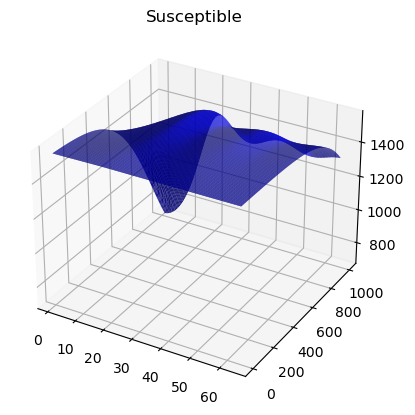

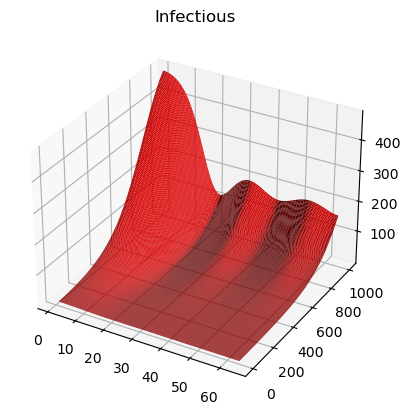

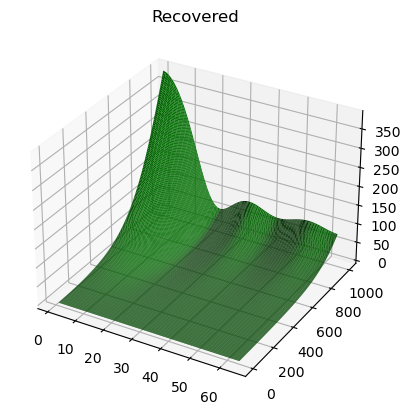

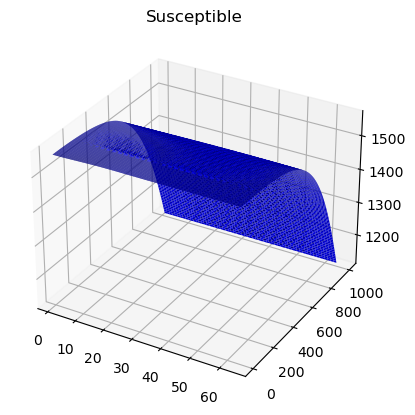

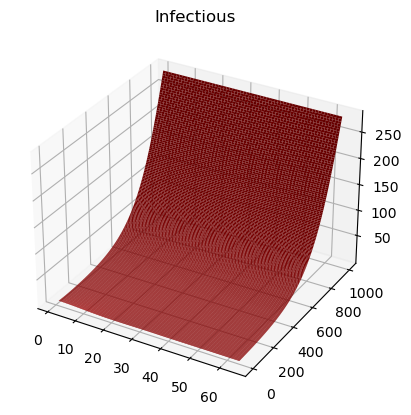

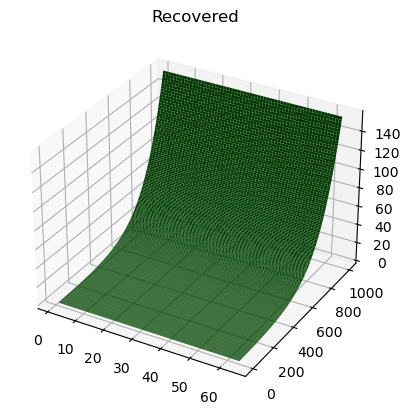

In [94]:
α = 1.
L = 0.1
κ = (L/2)^(1/α)
sol = SIRS_diffusion(S_0, I_0, R_0, β, γ, ω, μ, p, L, t_max, κ, α);

α = 1.
L = 100.
κ = (L/2)^(1/α)
sol = SIRS_diffusion(S_0, I_0, R_0, β, γ, ω, μ, p, L, t_max, κ, α);